In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Trích xuất đặc trưng


In [4]:
from skimage.feature import hog
from skimage import color
from PIL import Image
import numpy as np

def extract_hog_features(image_path):
    # Đọc và chuyển ảnh sang grayscale, resize
    image = Image.open(image_path).resize((128, 128)).convert("L")
    image = np.array(image, dtype=np.float32) / 255.0  # chuẩn hóa về [0, 1]

    # Trích xuất đặc trưng HOG
    features = hog(
        image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        transform_sqrt=True,
        feature_vector=True
    )

    return features

#### Hàm mô hình RandomForest

In [5]:

import numpy as np
import os
import pandas as pd
from tqdm import tqdm
from collections import Counter
from sklearn.tree import DecisionTreeClassifier

class SimpleRandomForestClassifier:
    def __init__(self, n_estimators=10, max_features='sqrt', random_state=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.trees = []
        self.features_indices = []
        self.random_state = random_state
        if random_state is not None:
            np.random.seed(random_state)

    def _get_max_features(self, n_features):
        if self.max_features == 'sqrt':
            return max(1, int(np.sqrt(n_features)))
        elif self.max_features == 'log2':
            return max(1, int(np.log2(n_features)))
        elif isinstance(self.max_features, int):
            return self.max_features
        else:
            return n_features  # dùng tất cả đặc trưng

    def fit(self, X, y):
        n_samples, n_features = X.shape
        max_feats = self._get_max_features(n_features)

        self.trees = []
        self.features_indices = []

        for _ in range(self.n_estimators):
            # Bootstrap sampling
            indices = np.random.choice(n_samples, size=n_samples, replace=True)
            X_sample = X[indices]
            y_sample = np.array(y)[indices]

            # Chọn ngẫu nhiên subset features
            feat_indices = np.random.choice(n_features, max_feats, replace=False)
            self.features_indices.append(feat_indices)

            # Huấn luyện cây quyết định trên dữ liệu mẫu và subset feature
            tree = DecisionTreeClassifier(random_state=self.random_state)
            tree.fit(X_sample[:, feat_indices], y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = []
        for tree, feat_idx in zip(self.trees, self.features_indices):
            preds = tree.predict(X[:, feat_idx])
            tree_preds.append(preds)
        tree_preds = np.array(tree_preds)  # shape (n_estimators, n_samples)

        # Đa số phiếu theo cột (theo mẫu)
        y_pred = []
        for i in range(tree_preds.shape[1]):
            votes = tree_preds[:, i]
            most_common = Counter(votes).most_common(1)[0][0]
            y_pred.append(most_common)
        return np.array(y_pred)



In [6]:
# Đọc dữ liệu
df = pd.read_csv("/content/drive/MyDrive/GI - ML/cleaned_data.csv")
image_folder = "/content/drive/MyDrive/GI - ML/datasets/Images"

X = []
y_object = []
y_action = []
y_color = []
y_location = []

print("Extracting features...")
for _, row in tqdm(df.iterrows(), total=len(df)):
    image_path = os.path.join(image_folder, row["image"])
    if not os.path.exists(image_path):
        continue
    try:
        feat = extract_hog_features(image_path)
        X.append(feat)
        y_object.append(row["object"])
        y_action.append(row["action"])
        y_color.append(row["color"])
        y_location.append(row["location"])
    except Exception as e:
        print(f"Error with {image_path}: {e}")

X = np.array(X)

# Tách train-test
from sklearn.model_selection import train_test_split
X_train_obj, X_test_obj, y_train_obj, y_test_obj = train_test_split(X, y_object, test_size=0.2, random_state=42)
X_train_act, X_test_act, y_train_act, y_test_act = train_test_split(X, y_action, test_size=0.2, random_state=42)
X_train_color, X_test_color, y_train_color, y_test_color = train_test_split(X, y_color, test_size=0.2, random_state=42)
X_train_loc, X_test_loc, y_train_loc, y_test_loc = train_test_split(X, y_location, test_size=0.2, random_state=42)

# Khởi tạo và huấn luyện các mô hình
clf_obj = SimpleRandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=42)
clf_obj.fit(X_train_obj, y_train_obj)

clf_act = SimpleRandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=42)
clf_act.fit(X_train_act, y_train_act)

clf_color = SimpleRandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=42)
clf_color.fit(X_train_color, y_train_color)

clf_loc = SimpleRandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=42)
clf_loc.fit(X_train_loc, y_train_loc)


Extracting features...


100%|██████████| 8092/8092 [33:12<00:00,  4.06it/s]  


In [7]:
def generate_caption(image_path):
    feat = extract_hog_features(image_path).reshape(1, -1)
    obj = clf_obj.predict(feat)[0]
    act = clf_act.predict(feat)[0]
    color = clf_color.predict(feat)[0]
    loc = clf_loc.predict(feat)[0]

    # Xây dựng từng phần nếu không phải 'unknown'
    parts = []

    if color != 'unknown':
        parts.append(f"{color}")
    if obj != 'unknown':
        parts.append(f"{obj}")

    subject = " ".join(parts) if parts else "something"

    if act != 'unknown':
        verb_phrase = f"is {act}"
    else:
        verb_phrase = ""

    if loc != 'unknown':
        loc_phrase = f"in the {loc}"
    else:
        loc_phrase = ""

    # Kết hợp lại thành câu
    caption_parts = [f"A {subject}"]
    if verb_phrase:
        caption_parts.append(verb_phrase)
    if loc_phrase:
        caption_parts.append(loc_phrase)

    caption = " ".join(caption_parts) + "."

    return caption

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image_with_caption(image_path):
    caption = generate_caption(image_path)
    img = mpimg.imread(image_path)

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=14, pad=20)
    plt.show()


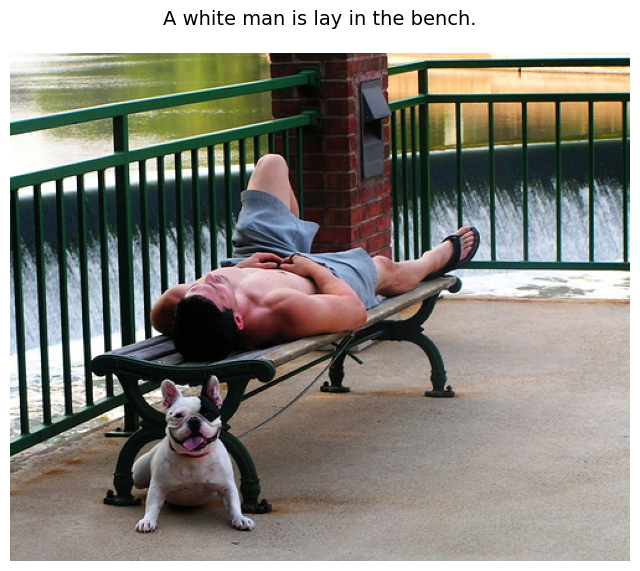

In [16]:
show_image_with_caption("/content/drive/MyDrive/GI - ML/datasets/Images/1003163366_44323f5815.jpg")


In [22]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Nếu chưa cài nltk data thì chạy lần đầu
nltk.download('punkt')

# Đọc các câu tham chiếu từ file
with open('/content/drive/MyDrive/GI - ML/datasets/Flickr8k.token.txt', 'r', encoding='utf-8') as f:
    references = f.readlines()

# Tiền xử lý: lowercase và strip
references = [ref.strip().lower() for ref in references if len(ref.strip()) > 0]

# Tokenize caption sinh ra
candidate = caption.lower()

# Tính BLEU score (câu caption so với toàn bộ tham chiếu)
references_tokenized = [word_tokenize(ref) for ref in references]
candidate_tokenized = word_tokenize(candidate)
bleu_score = sentence_bleu(references_tokenized, candidate_tokenized)
print(f"BLEU score: {bleu_score:.4f}")

# Tính cosine similarity

# Tạo vectorizer
vectorizer = TfidfVectorizer()

# Cùng đưa caption và tất cả câu tham chiếu vào vectorizer
all_sentences = references + [candidate]

# Vector hóa
tfidf_matrix = vectorizer.fit_transform(all_sentences)

# Vector caption là vector cuối cùng
candidate_vec = tfidf_matrix[-1]

# Vector câu tham chiếu là các vector đầu
reference_vecs = tfidf_matrix[:-1]

# Tính cosine similarity giữa caption và từng câu tham chiếu
cosine_similarities = cosine_similarity(candidate_vec, reference_vecs).flatten()

# In kết quả cosine similarity cao nhất và trung bình
print(f"Max cosine similarity: {np.max(cosine_similarities):.4f}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


BLEU score: 0.5000
Max cosine similarity: 0.4208


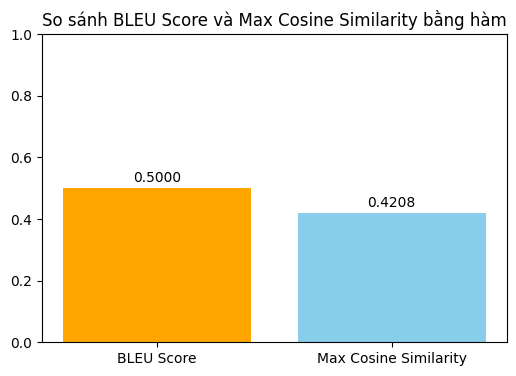

In [23]:
import matplotlib.pyplot as plt

# Hai giá trị bạn đã tính
bleu_score_value = bleu_score
max_cosine_similarity_value = np.max(cosine_similarities)

# Tên các chỉ số
metrics = ['BLEU Score', 'Max Cosine Similarity']
values = [bleu_score_value, max_cosine_similarity_value]

# Vẽ bar chart
plt.figure(figsize=(6,4))
bars = plt.bar(metrics, values, color=['orange', 'skyblue'])

# Ghi giá trị lên trên cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')

plt.ylim(0, 1)
plt.title('So sánh BLEU Score và Max Cosine Similarity bằng hàm')
plt.show()

